In [5]:
# helps in reading geojson files without resorting to value errors
import os
os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd

In [19]:
# import all required libraries
import esda, json, os
import pandas as pd
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Downloaded data from <a href = "https://data-ltsb.opendata.arcgis.com/datasets/LTSB::2012-2020-election-data-with-2020-wards/explore"> Wisconsin State Legislature Website </a>

<AxesSubplot:>

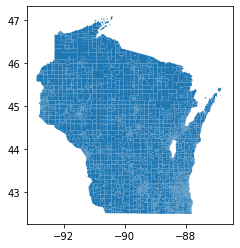

In [14]:
# reading geojson downloaded from opendata portal
wi_gdf = gpd.read_file(r"2012-2020_Election_Data_with_2020_Wards.geojson")
wi_gdf.plot()

In [16]:
# selecting Dane County to perform calculations
dane_county= gdf[(gdf['CNTY_NAME']=='Dane')]
dane_county.head(1)

,OBJECTID,GEOID,CNTY_FIPS,CNTY_NAME,COUSUBFP,MCD_FIPS,MCD_NAME,CTV,LABEL,LSAD,...,WSASCT12,WSSTOT12,WSSDEM12,WSSREP12,WSSREP212,WSSCON12,WSSIND12,WSSSCT12,WSSAME12,geometry
818,819,55025008750001,55025,Dane,00875,5502500875,Albion,T,Albion - T 0001,43,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-89.04186 42.86069, -89.04260 42.861..."


Text(0.5, 1.0, 'Election wards 2022 Dane County, WI')

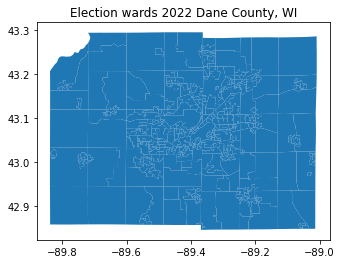

In [20]:
dane_county.plot()
plt.title("Election wards 2022 Dane County, WI")

In [35]:
# replacing all NaN values with zero
dane_county = dane_county.fillna(0)

<b>Variables in each voting district (WARD)</b>
<ul>
<li>Democratic Votes: <b>PREDEM20</b></li>
<li>Republican Votes: <b>PREREP20</b></li>
<li>Total Votes: <b>PRETOT20</b></li>
</ul>

In [73]:
# calculates number of polled votes
def polled_votes(row):
    return (row['PREDEM20'] + row['PREREP20'])

# calculates Democrat voting percentage for a given ward based on polled votes
def dem_voters(row):
    if not row['PRETOT20'] == 0:
        result = (row['PREDEM20']/row['TOTP_VOT'])*100
        return round(result,2)
    else:
        return 0

# calculates Republican voting percentage for a given ward based on polled votes
def rep_voters(row):
    if not row['PRETOT20'] == 0:
        result = (row['PREREP20']/row['TOTP_VOT'])*100
        return round(result,2)
    else: 
        return 0

In [74]:
dane_county['TOTP_VOT'] = dane_county.apply(lambda row: polled_votes(row), axis = 1)
dane_county['DEM_PCT'] = dane_county.apply(lambda row: dem_voters(row), axis = 1)
dane_county['REP_PCT'] = dane_county.apply(lambda row: rep_voters(row), axis = 1)

In [81]:
# calculates Democrat wasted votes for a given ward based on polled votes
def dem_wasted_votes(row):
    if row['DEM_PCT'] >= 50.1:
        excess_pct = (row['DEM_PCT']-50.1)
        if excess_pct > 0:
            wasted_votes = (excess_pct/100)*row['TOTP_VOT']
            return round(wasted_votes)
        else: 
            return 0
    else:
        return 0
    
dane_county['DEM_WST_VOT'] = dane_county.apply(lambda row: dem_wasted_votes(row), axis = 1)

In [83]:
# printing data frame to understand calculations
dane_df = dane_county[['GEOID', 'CNTY_NAME', 'MCD_NAME', 'PREDEM20', 'PREREP20', 'PRETOT20', 'DEM_PCT', 'REP_PCT', 'TOTP_VOT', 'DEM_WST_VOT']]
dane_df

,GEOID,CNTY_NAME,MCD_NAME,PREDEM20,PREREP20,PRETOT20,DEM_PCT,REP_PCT,TOTP_VOT,DEM_WST_VOT
818,55025008750001,Dane,Albion,323.0,288.0,624.0,52.86,47.14,611.0,17
819,55025008750002,Dane,Albion,340.0,302.0,654.0,52.96,47.04,642.0,18
820,55025063000001,Dane,Belleville,443.0,196.0,655.0,69.33,30.67,639.0,123
821,55025063000002,Dane,Belleville,429.0,189.0,630.0,69.42,30.58,618.0,119
822,55025070250001,Dane,Berry,176.0,135.0,316.0,56.59,43.41,311.0,20
...,...,...,...,...,...,...,...,...,...,...
1301,55025515750022,Dane,Middleton,0.0,0.0,0.0,0.00,0.00,0.0,0
1302,55025776750016,Dane,Stoughton,0.0,0.0,0.0,0.00,0.00,0.0,0
1303,55025786000027,Dane,Sun Prairie,0.0,0.0,0.0,0.00,0.00,0.0,0
1304,55025877250010,Dane,Windsor,354.0,202.0,564.0,63.67,36.33,556.0,75


In [89]:
y = dane_county['DEM_WST_VOT'] # target variable
wq =  lps.weights.Queen.from_dataframe(dane_county) # compute the spatial weights
wq.transform = 'r' # spatial weights require that the matrix is row-standardized 
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.4855127911687452